In [57]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon, shape
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from scipy.ndimage import distance_transform_edt, label, binary_dilation
import random
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator
from IPython.display import clear_output
from shapely.ops import unary_union
from skimage.measure import find_contours
from scipy.special import expit  # Logistic sigmoid function
import logging
from typing import Dict, Tuple, List, Optional


In [2]:

# =======================
# Loading data
# =======================

precinct_shapefile = 'fl_2016/fl_2016.shp'
votes_gdf = gpd.read_file(precinct_shapefile)

# calculate votes (blue = democrat, red = republican)
votes_gdf['blue'] = votes_gdf['G16PREDCLI'] + votes_gdf['G16USSDMUR']  # Blue votes
votes_gdf['red'] = votes_gdf['G16PRERTRU'] + votes_gdf['G16USSRRUB']   # Red votes

# Reproject to a Projected CRS
votes_gdf_projected = votes_gdf.to_crs(epsg=3857)

# calculate area to get pop per pixel
votes_gdf_projected['area'] = votes_gdf_projected.geometry.area


# =======================
# Rasterizing
# =======================

# select columns to be rasterized
# (to calculate total votes per pixel)
selected_columns = ['blue', 'red']

# get coordinates
minx, miny, maxx, maxy = votes_gdf_projected.total_bounds
pixel_size = 6000  # Adjust pixel size as needed (in meters)
width = int(np.ceil((maxx - minx) / pixel_size))
height = int(np.ceil((maxy - miny) / pixel_size))
transform = from_bounds(minx, miny, maxx, maxy, width, height)

# rasterize attributes
raster_bands = []
for col in selected_columns:
    # Create shapes for rasterization with scaled values
    shapes = (
        (geom, value)
        for geom, value in zip(votes_gdf_projected.geometry, votes_gdf_projected[col])
    )
    raster_band = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='float32'
    )
    raster_bands.append(raster_band)

blue_band, red_band = raster_bands

# total votes/population per pixel
population = blue_band + red_band 

# =======================
# Florida mask
# this part ignores pixels that are not within Florida
# =======================

# get the boundary of Florida state
florida_union = votes_gdf_projected.union_all()

# Ensure the union is a Polygon or MultiPolygon
if not isinstance(florida_union, (Polygon, MultiPolygon)):
    raise ValueError("Unexpected geometry type for unary_union. Expected Polygon or MultiPolygon.")

# Rasterize the Florida boundary to create a mask
florida_mask = rasterize(
    [(florida_union, 1)], # 1 is pixel is inside, 0 otherwise
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)

# Apply the Florida mask to the population array
# Pixels outside Florida will have population = 0
population_masked = population * florida_mask


In [3]:

def generate_voronoi_districts(population_masked, num_districts=27, random_seed=None):
    """
    Generates Voronoi-based districts within Florida based on a population raster.

    Parameters:
        population_masked (np.ndarray): 2D array representing population per pixel within Florida.
        num_districts (int): Number of districts to generate. Default is 27.
        tolerance (float): Population tolerance (unused in Voronoi, but kept for reference). Default is 50000.
        random_seed (int, optional): Seed for random number generator for reproducibility.

    Returns:
        district_map (np.ndarray): 2D array with district IDs assigned to each pixel. Pixels outside Florida are -1.
        seed_coords (np.ndarray): Array of shape (num_districts, 2) with seed pixel coordinates (row, column).
        target_pop (float): Target population per district.
    """
    # specify seed for reproducibility
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)

    # Calculate total and target population
    total_pop = population_masked.sum()
    target_pop = total_pop / num_districts
    # print("Total population within Florida:", total_pop)
    # print("Target population per district:", target_pop)

    # =======================
    # Voronoi Tesselation
    # =======================

    # get pixels within Florida
    valid_pixels = np.argwhere(population_masked > 0)
    if len(valid_pixels) < num_districts:
        raise ValueError("Not enough valid pixels to assign to districts.")

    # randomly sample 27 pixels (one for each district)
    seed_indices = random.sample(range(valid_pixels.shape[0]), num_districts)
    seed_coords = valid_pixels[seed_indices]

    # create an empty district map
    # initialize with -1 for ocean pixels (outside Florida)
    height, width = population_masked.shape
    district_map = -1 * np.ones((height, width), dtype=int)

    # assign each sampled pixel to a district
    for d_id, (r, c) in enumerate(seed_coords):
        district_map[r, c] = d_id

    # compute Voronoi Tessellation
    # Create a boolean array where seed pixels are True
    seed_mask = np.zeros((height, width), dtype=bool)
    seed_mask[seed_coords[:, 0], seed_coords[:, 1]] = True

    # find the nearest pixel to each sampled pixel
    distance, indices = distance_transform_edt(~seed_mask, return_indices=True)

    # assign each pixel to the nearest seed's district ID
    nearest_row = indices[0]
    nearest_col = indices[1]
    nearest_district = district_map[nearest_row, nearest_col]

    # update the district map for all valid pixels
    district_map[population_masked > 0] = nearest_district[population_masked > 0]

    # =======================
    # Calculate Population and Vote Percentages
    # =======================

    # Initialize lists to store data for each district
    district_ids = range(num_districts)
    total_population = []
    total_blue = []
    total_red = []
    percentage_blue = []
    percentage_red = []

    # create data frame with population and votes per district
    # ---------------------------------------

    for d_id in district_ids:
        # Create a mask for the current district
        mask = (district_map == d_id)
        
        # Calculate total population for the district
        pop = population_masked[mask].sum()
        total_population.append(pop)
        
        # Calculate total blue and red votes for the district
        blue = blue_band[mask].sum()
        red = red_band[mask].sum()
        total_blue.append(blue)
        total_red.append(red)
        
        # Calculate percentage of blue and red votes
        if pop > 0:
            percentage_blue.append((blue / pop) * 100.0)
            percentage_red.append((red / pop) * 100.0)
        else:
            percentage_blue.append(0)
            percentage_red.append(0)
    
    # ---------------------------------------

    data = {
        'District': district_ids,
        'Total Population': total_population,
        'Blue Votes': total_blue,
        'Red Votes': total_red,
        'Percentage Blue': percentage_blue,
        'Percentage Red': percentage_red
    }

    df = pd.DataFrame(data)

    # =======================
    # Plots:
    # =======================

    #  Voronoi Districts
    # ------------------------
    district_colors = plt.get_cmap('tab20', num_districts).colors[:num_districts]
    colors = list(district_colors) + [(0, 0, 0, 1)]  # Adding black for ocean
    custom_cmap = ListedColormap(colors)

    # Adjust district_map to Shift -1 to the Last Index (for black color)
    district_map_shifted = district_map.copy()
    district_map_shifted[district_map_shifted == -1] = num_districts  # Assign -1 to black

    # Combine all plots in 1 row, 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot 1
    im = axes[0].imshow(
        district_map_shifted,
        cmap=custom_cmap,
        interpolation='nearest',
        origin='upper',
        extent=(minx, maxx, miny, maxy)
    )
    axes[0].grid(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title("Voronoi Districts", fontsize=14)

    # Population and Votes per District
    # ------------------------
    # Plot 2: Total Population per District
    axes[1].bar(df['District'], df['Total Population'], color='lightgreen')
    axes[1].set_xlabel('District ID', fontsize=12)
    axes[1].set_ylabel('Total Population', fontsize=12)
    axes[1].set_title('Total Population per District', fontsize=14)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 3: Percentage of Blue vs Red Votes per District
    width = 0.6  # Width of the bars
    axes[2].bar(df['District'], df['Percentage Blue'], width, label='Blue', color='skyblue')
    axes[2].bar(df['District'], df['Percentage Red'], width, bottom=df['Percentage Blue'], label='Red', color='pink')
    axes[2].set_xlabel('District ID', fontsize=12)
    axes[2].set_ylabel('Percentage of Votes (%)', fontsize=12)
    axes[2].set_title('Percentage of Blue vs Red Votes', fontsize=14)
    axes[2].legend(fontsize=10)
    axes[2].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # =======================
    
    return district_map, seed_coords, target_pop


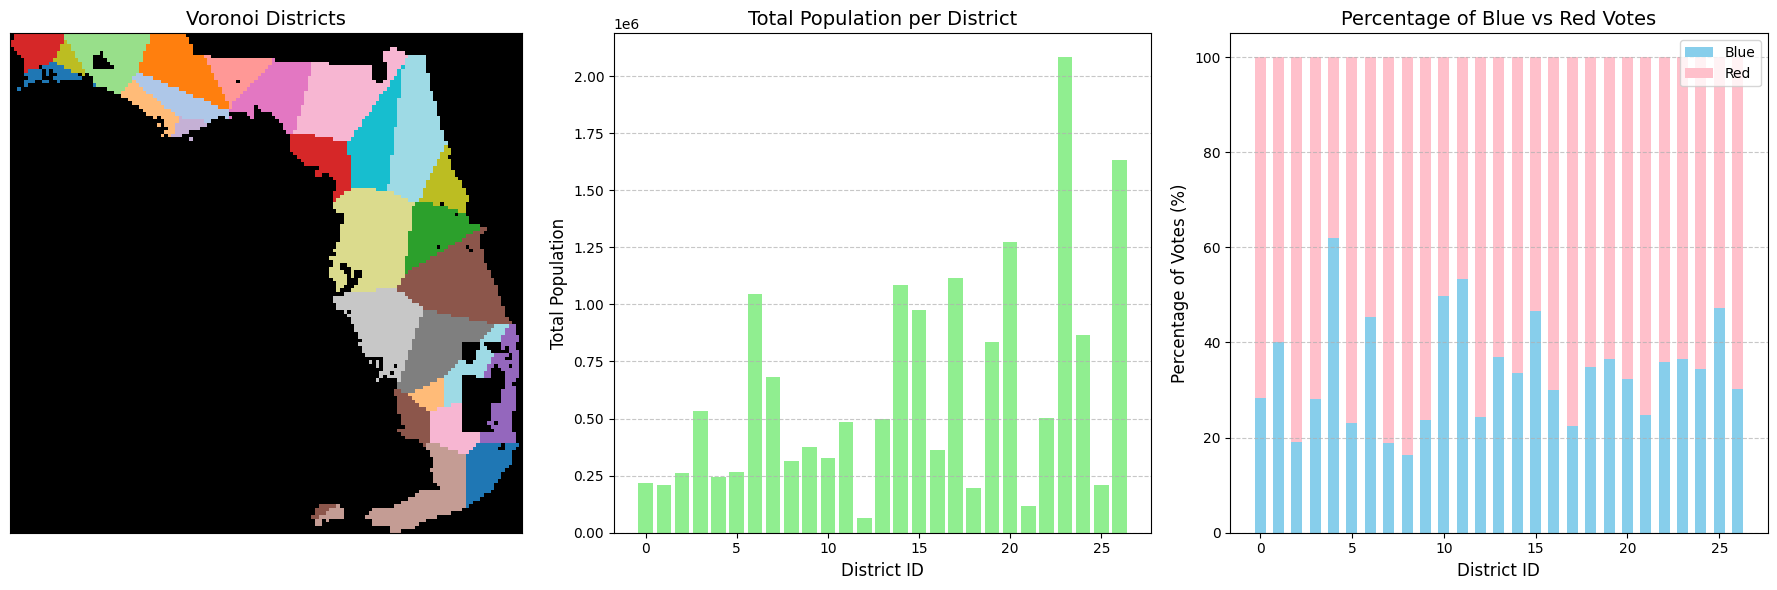

In [55]:
district_map, seed_coords, target_pop = generate_voronoi_districts(population_masked, 27)

**Plot Function**

In [58]:
def plot_map(
    district_map: np.ndarray,
    population_masked: np.ndarray,
    num_districts: int,
    iteration: Optional[int] = None,
    population_losses: Optional[List[float]] = None,
    compactness_losses: Optional[List[float]] = None,
    alignment_losses: Optional[List[float]] = None,
    total_losses: Optional[List[float]] = None,
    temperatures: Optional[List[float]] = None,
    blue_votes: Optional[Dict[int, float]] = None,
    red_votes: Optional[Dict[int, float]] = None
) -> None:
    """
    Dynamically visualize the district map, votes per district, and loss curves in an interactive manner.

    Parameters:
        district_map (np.ndarray): 2D array of district IDs.
        population_masked (np.ndarray): 2D array of population values per pixel.
        num_districts (int): Total number of districts.
        iteration (int, optional): Current iteration number to include in the plot title.
        population_losses (list, optional): List of population losses over iterations.
        compactness_losses (list, optional): List of compactness losses over iterations.
        alignment_losses (list, optional): List of alignment losses over iterations.
        total_losses (list, optional): List of total losses over iterations.
        temperatures (list, optional): List of temperatures over iterations.
        blue_votes (dict, optional): Dictionary with blue votes per district.
        red_votes (dict, optional): Dictionary with red votes per district.
    """
    # Clear the current output (useful in Jupyter notebooks)
    clear_output(wait=True)

    # Calculate population per district
    population_per_district = np.bincount(district_map.ravel(), weights=population_masked.ravel(), minlength=num_districts)
    total_population = population_per_district[:num_districts]

    # Calculate vote percentages per district
    blue_percentages = np.zeros(num_districts)
    red_percentages = np.zeros(num_districts)

    if blue_votes and red_votes:
        for d_id in range(num_districts):
            total_blue = blue_votes.get(d_id, 0)
            total_red = red_votes.get(d_id, 0)
            total = total_blue + total_red
            if total > 0:
                blue_percentages[d_id] = (total_blue / total) * 100
                red_percentages[d_id] = (total_red / total) * 100
            else:
                blue_percentages[d_id] = 0
                red_percentages[d_id] = 0

    # Create a dynamic colormap to handle any number of districts
    base_cmap = plt.get_cmap('tab20')
    if num_districts <= 20:
        district_colors = base_cmap.colors[:num_districts]
    else:
        # Generate a larger list of colors by repeating the base colormap
        repeats = (num_districts // len(base_cmap.colors)) + 1
        district_colors = (base_cmap.colors * repeats)[:num_districts]
    custom_colors = list(district_colors) + [(0, 0, 0, 1)]  # Black for -1
    custom_cmap = ListedColormap(custom_colors)

    # Shift -1 to the last index for coloring
    district_map_shifted = district_map.copy()
    district_map_shifted[district_map_shifted == -1] = num_districts

    # Initialize figure and axes
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle(f"District Map and Metrics" + (f" - Iteration {iteration}" if iteration is not None else ""), fontsize=16)

    # --- Plot 1: District Map ---
    ax_map = axes[0, 0]
    im = ax_map.imshow(
        district_map_shifted,
        cmap=custom_cmap,
        interpolation='nearest',
        origin='upper'
    )
    ax_map.set_title("District Map" + (f" - Iteration {iteration}" if iteration is not None else ""))
    ax_map.set_xticks([])
    ax_map.set_yticks([])
    # Create a legend for districts if num_districts is small
    if num_districts <= 20:
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=custom_colors[d_id], edgecolor='k', label=f'District {d_id}') for d_id in range(num_districts)]
        ax_map.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # --- Plot 2: Votes per District ---
    ax_votes = axes[0, 1]
    if blue_votes and red_votes:
        width = 0.35  # Width of the bars
        x = np.arange(num_districts)
        ax_votes.bar(x - width/2, blue_percentages, width, label='Blue %', color='skyblue')
        ax_votes.bar(x + width/2, red_percentages, width, label='Red %', color='lightcoral')
        ax_votes.set_xlabel('District ID', fontsize=12)
        ax_votes.set_ylabel('Vote Percentage (%)', fontsize=12)
        ax_votes.set_title('Vote Percentages per District', fontsize=14)
        ax_votes.set_xticks(x)
        ax_votes.set_xticklabels([str(d_id) for d_id in range(num_districts)])
        ax_votes.legend(fontsize=10)
        ax_votes.grid(axis='y', linestyle='--', alpha=0.7)
    else:
        ax_votes.text(0.5, 0.5, 'Vote Data Not Available', horizontalalignment='center', verticalalignment='center', fontsize=14)
        ax_votes.axis('off')

    # --- Plot 3: Population per District ---
    ax_population = axes[1, 0]
    ax_population.bar(range(num_districts), total_population, color='lightgreen')
    ax_population.set_xlabel('District ID', fontsize=12)
    ax_population.set_ylabel('Total Population', fontsize=12)
    ax_population.set_title('Population per District', fontsize=14)
    ax_population.set_xticks(range(num_districts))
    ax_population.set_xticklabels([str(d_id) for d_id in range(num_districts)])
    ax_population.grid(axis='y', linestyle='--', alpha=0.7)

    # --- Plot 4: Loss Plot ---
    ax_loss = axes[1, 1]
    if all([population_losses, compactness_losses, alignment_losses, total_losses]):
        ax_loss.plot(population_losses, label="Population Loss", linestyle='-', alpha=0.8)
        ax_loss.plot(compactness_losses, label="Compactness Loss", linestyle='--', alpha=0.8)
        ax_loss.plot(alignment_losses, label="Alignment Loss", linestyle=':', alpha=0.8)
        ax_loss.plot(total_losses, label="Total Loss", linestyle='-.', alpha=0.8)
        ax_loss.set_title("Loss Over Iterations", fontsize=14)
        ax_loss.set_xlabel("Iteration", fontsize=12)
        ax_loss.set_ylabel("Loss", fontsize=12)
        ax_loss.legend()
        ax_loss.grid(axis='y', linestyle='--', alpha=0.7)
    else:
        ax_loss.text(0.5, 0.5, 'Loss Data Not Available', horizontalalignment='center', verticalalignment='center', fontsize=14)
        ax_loss.axis('off')

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Display the figure
    display(fig)
    plt.pause(0.1)  # Brief pause to ensure the plot updates in Jupyter
    plt.close(fig)


In [59]:
def enforce_largest_connected_component(district_map):
    """
    Enforce contiguity by retaining only the largest connected component
    across the entire district map, removing all other smaller components.

    Parameters:
        district_map (np.ndarray): 2D array with district IDs (>= 0) and -1 for outside areas.

    Returns:
        np.ndarray: Updated district map with only the largest connected component retained.
    """
    # Mask to ignore ocean/outside (-1)
    valid_mask = district_map >= 0

    # Label connected components across the entire map
    labeled, num_components = label(valid_mask)

    if num_components <= 1:
        return district_map  # Already one connected component

    # Find the largest connected component
    component_sizes = [(comp_label, np.sum(labeled == comp_label)) for comp_label in range(1, num_components + 1)]
    largest_label = max(component_sizes, key=lambda x: x[1])[0]  # Find label with the largest size

    # Create a mask for the largest connected component
    largest_component_mask = (labeled == largest_label)

    # Set all other regions to -1 (outside)
    district_map[~largest_component_mask] = -1

    return district_map

In [60]:
district_map = enforce_largest_connected_component(district_map)

In [ ]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def calculate_victory_probabilities(district_map: np.ndarray, blue_band: np.ndarray, red_band: np.ndarray, num_districts: int) -> Dict[int, float]:
    """
    Calculate the normalized victory probabilities for each district, excluding -1 entries.

    Parameters:
        district_map (np.ndarray): 2D array of district IDs.
        blue_band (np.ndarray): 2D array of blue votes per pixel.
        red_band (np.ndarray): 2D array of red votes per pixel.
        num_districts (int): Total number of districts.

    Returns:
        Dict[int, float]: Victory probabilities for each district.
    """
    mask = district_map >= 0  # Exclude -1 entries
    district_ids = np.unique(district_map[mask])
    blue_totals = np.bincount(district_map[mask].ravel(), weights=blue_band[mask].ravel(), minlength=num_districts)
    red_totals = np.bincount(district_map[mask].ravel(), weights=red_band[mask].ravel(), minlength=num_districts)
    victory_probs = {}
    for d_id in district_ids:
        total_blue = blue_totals[d_id]
        total_red = red_totals[d_id]
        if total_blue + total_red > 0:
            normalized_share = total_blue / (total_blue + total_red)
        else:
            normalized_share = 0.5
        prob_blue_win = expit((normalized_share - 0.5) * 10)  # Sharp transition at 50%
        victory_probs[d_id] = prob_blue_win
    return victory_probs


def calculate_target_alignment_loss(victory_probs: Dict[int, float], target_blue: int) -> float:
    """
    Calculate the loss for alignment with the target number of blue districts.

    Parameters:
        victory_probs (Dict[int, float]): Probabilities of blue victory for each district.
        target_blue (int): Target number of blue districts.

    Returns:
        float: Target alignment loss.
    """
    expected_blue_wins = sum(prob > 0.5 for prob in victory_probs.values())
    alignment_loss = (target_blue - expected_blue_wins) ** 2
    return alignment_loss

def calculate_district_populations(district_map: np.ndarray, population_masked: np.ndarray) -> Dict[int, float]:
    """
    Calculate the population for each district, excluding areas marked as -1.

    Parameters:
        district_map (np.ndarray): 2D array of district IDs.
        population_masked (np.ndarray): 2D array of population values.

    Returns:
        Dict[int, float]: Population of each district.
    """
    mask = district_map >= 0  # Exclude -1 entries
    district_ids = np.unique(district_map[mask])
    pop_totals = np.bincount(district_map[mask].ravel(), weights=population_masked[mask].ravel())
    pop_dict = {d_id: pop_totals[d_id] for d_id in district_ids.astype(int)}
    return pop_dict

def calculate_compactness(district_map: np.ndarray, district_id: int) -> float:
    """
    Calculate the compactness (Polsby-Popper metric) of a district.

    Parameters:
        district_map (np.ndarray): 2D array of district IDs.
        district_id (int): ID of the district to evaluate.

    Returns:
        float: Compactness score (lower is better).
    """
    district_mask = (district_map == district_id)
    if not district_mask.any():
        return float('inf')

    contours = find_contours(district_mask.astype(float), 0.5)
    if not contours:
        return float('inf')

    polygons = []
    for contour in contours:
        if len(contour) >= 3:
            poly = Polygon(contour)
            if poly.is_valid and poly.area > 0:
                polygons.append(poly)

    if not polygons:
        return float('inf')

    district_polygon = unary_union(polygons)
    perimeter = district_polygon.length
    area = district_polygon.area
    if area == 0:
        return float('inf')

    # Polsby-Popper: 4π * Area / Perimeter^2 (higher is better compactness)
    polsby_popper = (4 * np.pi * area) / (perimeter ** 2)
    # To align with the original loss where lower is better, take inverse
    compactness_score = 1 / polsby_popper if polsby_popper > 0 else float('inf')
    return compactness_score

def calculate_loss(district_map: np.ndarray, pop_dict: Dict[int, float], target_pop: float, alpha: float, beta: float) -> Tuple[float, float, float]:
    """
    Calculate the combined loss (population imbalance + compactness).

    Parameters:
        district_map (np.ndarray): 2D array of districts.
        pop_dict (Dict[int, float]): Population of each district.
        target_pop (float): Target population per district.
        alpha (float): Weight for compactness.
        beta (float): Weight for population imbalance.

    Returns:
        Tuple[float, float, float]: Population imbalance, compactness score, and combined loss.
    """
    # Population imbalance
    pop_values = np.array(list(pop_dict.values()))
    pop_imbalance = np.sum((pop_values - target_pop) ** 2)
    weighted_pop_imbalance = beta * pop_imbalance

    # Compactness
    unique_districts = np.unique(district_map)
    unique_districts = unique_districts[unique_districts >= 0]
    compactness_scores = [calculate_compactness(district_map, d_id) for d_id in unique_districts.astype(int)]
    compactness_score = np.sum(compactness_scores)
    weighted_compactness = alpha * compactness_score

    # Combined loss
    total_loss = weighted_pop_imbalance + weighted_compactness

    return weighted_pop_imbalance, weighted_compactness, total_loss


def calculate_total_loss_with_targets(
    district_map: np.ndarray, blue_band: np.ndarray, red_band: np.ndarray, population_masked: np.ndarray,
    target_pop: float, target_blue: int, alpha: float, beta: float, lambda_align: float
) -> Tuple[float, float, float, float]:
    """
    Calculate the total loss including compactness, population imbalance, and political target alignment.

    Parameters:
        district_map (np.ndarray): 2D array of district IDs.
        blue_band (np.ndarray): 2D array of blue votes per pixel.
        red_band (np.ndarray): 2D array of red votes per pixel.
        population_masked (np.ndarray): 2D array of population values.
        target_pop (float): Target population per district.
        target_blue (int): Target number of blue districts.
        alpha (float): Weight for compactness.
        beta (float): Weight for population imbalance.
        lambda_align (float): Weight for target alignment.

    Returns:
        Tuple[float, float, float, float]: Population loss, compactness loss, alignment loss, total loss.
    """
    pop_dict = calculate_district_populations(district_map, population_masked)
    pop_loss, compact_loss, total_loss = calculate_loss(district_map, pop_dict, target_pop, alpha, beta)

    # Victory probabilities and target alignment
    victory_probs = calculate_victory_probabilities(district_map, blue_band, red_band, num_districts=27)
    align_loss = lambda_align * calculate_target_alignment_loss(victory_probs, target_blue)

    # Total loss
    total_loss += align_loss

    return pop_loss, compact_loss, align_loss, total_loss


def is_contiguous_after_flip(district_map: np.ndarray, current_d: int, r: int, c: int) -> bool:
    """
    Check if the district `current_d` remains contiguous after removing the pixel `(r, c)`.

    Parameters:
        district_map (np.ndarray): 2D array of districts.
        current_d (int): District ID of the pixel being removed.
        r (int): Row index of the pixel to remove.
        c (int): Column index of the pixel to remove.

    Returns:
        bool: True if the district remains contiguous, False otherwise.
    """
    district_mask = (district_map == current_d)
    # Remove the pixel
    district_mask[r, c] = False
    labeled, num_components = label(district_mask)
    return num_components <= 1

def flip_pixel(district_map: np.ndarray, pop_dict: Dict[int, float], pixel: Tuple[int, int], new_d: int, population_masked: np.ndarray) -> Tuple[np.ndarray, Dict[int, float]]:
    """
    Perform the flip of a pixel to a new district and update the population dictionary.

    Parameters:
        district_map (np.ndarray): 2D array of districts.
        pop_dict (Dict[int, float]): Population of each district.
        pixel (Tuple[int, int]): Coordinates of the pixel to flip.
        new_d (int): New district ID to assign.
        population_masked (np.ndarray): 2D array of population values.

    Returns:
        Tuple[np.ndarray, Dict[int, float]]: Updated district_map and pop_dict.
    """
    r, c = pixel
    old_d = district_map[r, c]
    pixel_pop = population_masked[r, c]

    # Update district_map
    district_map[r, c] = new_d

    # Update population dictionary
    pop_dict[old_d] -= pixel_pop
    pop_dict[new_d] += pixel_pop

    return district_map, pop_dict

def evaluate_flip_and_loss_optimized(
    district_map: np.ndarray, population_masked: np.ndarray, pop_dict: Dict[int, float], pixel: Tuple[int, int],
    target_pop: float, alpha: float, beta: float, lambda_align: float, target_blue: int, blue_band: np.ndarray,
    red_band: np.ndarray, current_loss: Tuple[float, float, float, float]
) -> Optional[Tuple[int, float, Tuple[float, float, float, float]]]:
    """
    Evaluate flipping a border pixel and calculate the resulting loss efficiently,
    ensuring districts remain contiguous.

    Parameters:
        district_map (np.ndarray): 2D array of districts.
        population_masked (np.ndarray): 2D array of population values per pixel.
        pop_dict (Dict[int, float]): Population of each district.
        pixel (Tuple[int, int]): Coordinates of the pixel to flip.
        target_pop (float): Target population per district.
        alpha (float): Weight for compactness.
        beta (float): Weight for population imbalance.
        lambda_align (float): Weight for target alignment.
        target_blue (int): Target number of blue districts.
        blue_band (np.ndarray): 2D array of blue votes per pixel.
        red_band (np.ndarray): 2D array of red votes per pixel.
        current_loss (Tuple[float, float, float, float]): Current losses (population loss, compactness loss, alignment loss, total loss).

    Returns:
        Optional[Tuple[int, float, Tuple[float, float, float, float]]]:
            Best new district ID, change in total loss, and updated loss values.
            Returns None if the flip is invalid.
    """
    current_pop_loss, current_compact_loss, current_align_loss, current_total_loss = current_loss
    r, c = pixel
    current_d = district_map[r, c]

    # Identify candidate new districts from neighbors
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    height, width = district_map.shape
    candidate_districts = set()
    for dr, dc in neighbors:
        nr, nc = r + dr, c + dc
        if 0 <= nr < height and 0 <= nc < width:
            neighbor_id = district_map[nr, nc]
            if neighbor_id >= 0 and neighbor_id != current_d:
                candidate_districts.add(neighbor_id)
    if not candidate_districts:
        return None  # No valid flip

    best_new_d = None
    best_delta_loss = float("inf")
    best_new_loss = current_loss

    pixel_pop = population_masked[r, c]

    for new_d in candidate_districts:
        # Check contiguity
        if not is_contiguous_after_flip(district_map, current_d, r, c):
            continue

        # Simulate the flip
        new_pop_dict = pop_dict.copy()
        new_pop_dict[current_d] -= pixel_pop
        new_pop_dict[new_d] += pixel_pop

        # Calculate population loss
        pop_loss_current = (pop_dict[current_d] - target_pop) ** 2 + (pop_dict[new_d] - target_pop) ** 2
        pop_loss_new = (new_pop_dict[current_d] - target_pop) ** 2 + (new_pop_dict[new_d] - target_pop) ** 2
        delta_pop_loss = beta * (pop_loss_new - pop_loss_current)

        # Calculate compactness loss
        compactness_current = calculate_compactness(district_map, current_d) + calculate_compactness(district_map, new_d)
        # Temporarily flip the pixel to calculate new compactness
        district_map[r, c] = new_d
        compactness_new = calculate_compactness(district_map, current_d) + calculate_compactness(district_map, new_d)
        district_map[r, c] = current_d  # Revert the flip
        delta_compact_loss = alpha * (compactness_new - compactness_current)

        # Calculate alignment loss
        # Recalculate victory probabilities
        victory_probs = calculate_victory_probabilities(district_map, blue_band, red_band, num_districts=27)
        # Update with the simulated flip
        # To accurately reflect the flip, we need to recalculate votes for affected districts
        # This is complex; instead, recalculate victory_probs after the flip
        # Thus, simulate the flip and recalculate
        district_map[r, c] = new_d
        updated_victory_probs = calculate_victory_probabilities(district_map, blue_band, red_band, num_districts=27)
        district_map[r, c] = current_d  # Revert the flip

        align_loss_current = lambda_align * calculate_target_alignment_loss(victory_probs, target_blue)
        align_loss_new = lambda_align * calculate_target_alignment_loss(updated_victory_probs, target_blue)
        delta_align_loss = align_loss_new - align_loss_current

        # Total delta loss
        delta_total_loss = delta_pop_loss + delta_compact_loss + delta_align_loss

        if delta_total_loss < best_delta_loss:
            best_delta_loss = delta_total_loss
            best_new_d = new_d
            # Update losses
            new_pop_loss = beta * np.sum((np.array(list(new_pop_dict.values())) - target_pop) ** 2)
            new_compact_loss = alpha * np.sum([calculate_compactness(district_map, d_id) for d_id in new_pop_dict.keys()])
            new_align_loss = lambda_align * calculate_target_alignment_loss(updated_victory_probs, target_blue)
            new_total_loss = new_pop_loss + new_compact_loss + new_align_loss
            best_new_loss = (new_pop_loss, new_compact_loss, new_align_loss, new_total_loss)

    if best_new_d is not None:
        return best_new_d, best_delta_loss, best_new_loss
    else:
        return None

def get_border_pixels(district_map: np.ndarray) -> List[Tuple[int, int]]:
    """
    Identify border pixels of districts. A border pixel is one that is part of a district
    but is adjacent to a pixel of a different district or -1.

    Parameters:
        district_map (np.ndarray): 2D array of district IDs.

    Returns:
        List[Tuple[int, int]]: List of border pixel coordinates.
    """
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    height, width = district_map.shape
    border_pixels = set()

    for r in range(height):
        for c in range(width):
            d_id = district_map[r, c]
            if d_id < 0:
                continue
            for dr, dc in neighbors:
                nr, nc = r + dr, c + dc
                if 0 <= nr < height and 0 <= nc < width:
                    neighbor_id = district_map[nr, nc]
                    if neighbor_id != d_id:
                        border_pixels.add((r, c))
                        break
    return list(border_pixels)

def optimize_district_map_with_targets(
    district_map: np.ndarray, blue_band: np.ndarray, red_band: np.ndarray, population_masked: np.ndarray,
    num_iterations_phase1: int, num_iterations_phase2: int, target_pop: float, target_blue: int,
    alpha: float, beta: float, lambda_align: float, initial_temp: float = 1.0,
    cooling_rate_phase1: float = 0.99, cooling_rate_phase2: float = 0.95, visualize_every: int = 100
) -> np.ndarray:
    """
    Optimize district map in two phases: first equalize population, then optimize for political favorability,
    with periodic visualization.

    Parameters:
        district_map (np.ndarray): 2D array of districts.
        blue_band (np.ndarray): 2D array of blue votes per pixel.
        red_band (np.ndarray): 2D array of red votes per pixel.
        population_masked (np.ndarray): 2D array of population values.
        num_iterations_phase1 (int): Number of iterations for the population equalization phase.
        num_iterations_phase2 (int): Number of iterations for the political favorability phase.
        target_pop (float): Target population per district.
        target_blue (int): Target number of blue districts.
        alpha (float): Weight for compactness.
        beta (float): Weight for population imbalance.
        lambda_align (float): Weight for target alignment.
        initial_temp (float): Initial temperature for simulated annealing.
        cooling_rate_phase1 (float): Cooling rate for phase 1.
        cooling_rate_phase2 (float): Cooling rate for phase 2.
        visualize_every (int): Number of iterations between visualizations.

    Returns:
        np.ndarray: Optimized district map.
    """
    def phase_optimization(
        phase_district_map: np.ndarray, num_iterations: int, cooling_rate: float,
        optimize_for_favorability: bool, phase_name: str
    ) -> Tuple[np.ndarray, Dict[int, float]]:
        pop_dict = calculate_district_populations(phase_district_map, population_masked)
        temp = initial_temp

        # Calculate initial loss
        current_losses = calculate_total_loss_with_targets(
            phase_district_map, blue_band, red_band, population_masked,
            target_pop, target_blue, alpha, beta, lambda_align
        )
        _, _, _, current_total_loss = current_losses

        for iteration in range(1, num_iterations + 1):
            border_pixels = get_border_pixels(phase_district_map)
            if not border_pixels:
                logging.info(f"No border pixels left to process in {phase_name}.")
                break

            pixel = random.choice(border_pixels)
            evaluation = evaluate_flip_and_loss_optimized(
                phase_district_map, blue_band, red_band, population_masked, pop_dict, pixel,
                target_pop, target_blue, alpha, beta, lambda_align
            )

            if evaluation is not None:
                new_d, delta_loss, new_losses = evaluation
                if delta_loss < 0 or (optimize_for_favorability and random.random() < np.exp(-delta_loss / temp)):
                    # Perform the flip
                    phase_district_map, pop_dict = flip_pixel(phase_district_map, pop_dict, pixel, new_d, population_masked)
                    current_losses = new_losses
                    current_total_loss += delta_loss
                    logging.debug(f"{phase_name} Iteration {iteration}: Flipped pixel {pixel} to district {new_d} with delta loss {delta_loss:.4f}")

            # Decrease temperature
            temp *= cooling_rate

            # Visualization or logging can be added here if needed
            if visualize_every > 0 and iteration % visualize_every == 0:
                logging.info(f"{phase_name} Iteration {iteration}: Total Loss = {current_total_loss:.4f}")

        return phase_district_map, pop_dict

    # Phase 1: Equalize Population
    logging.info("Starting Phase 1: Population Equalization")
    district_map, pop_dict = phase_optimization(
        district_map.copy(), num_iterations_phase1, cooling_rate_phase1,
        optimize_for_favorability=False, phase_name="Phase 1"
    )
    logging.info("Phase 1 Completed.")

    # Phase 2: Optimize for Political Favorability
    logging.info("Starting Phase 2: Political Favorability Optimization")
    district_map, pop_dict = phase_optimization(
        district_map.copy(), num_iterations_phase2, cooling_rate_phase2,
        optimize_for_favorability=True, phase_name="Phase 2"
    )
    logging.info("Phase 2 Completed.")

    return district_map

In [64]:
district_map = optimize_district_map_with_targets(
    district_map, blue_band, red_band, population_masked, 
    num_iterations_phase1=100000, num_iterations_phase2=100000, target_pop=target_pop, target_blue=14, 
    alpha=200, beta=1e-8, lambda_align=1000, visualize_every=1000
)



2024-12-09 15:59:30,332 - INFO - Starting Phase 1: Population Equalization


TypeError: calculate_victory_probabilities() missing 1 required positional argument: 'num_districts'